<a href="https://colab.research.google.com/github/amyhynes/COMP550-code/blob/master/replication_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# BERT End to End (Fine-tuning + Predicting) in 5 minutes with Cloud TPU

## Overview

**BERT**, or **B**idirectional **E**mbedding **R**epresentations from **T**ransformers, is a new method of pre-training language representations which obtains state-of-the-art results on a wide array of Natural Language Processing (NLP) tasks. The academic paper can be found here: https://arxiv.org/abs/1810.04805.

This Colab demonstates using a free Colab Cloud TPU to fine-tune sentence and sentence-pair classification tasks built on top of pretrained BERT models and 
run predictions on tuned model. The colab demonsrates loading pretrained BERT models from both [TF Hub](https://www.tensorflow.org/hub) and checkpoints.

**Note:**  You will need a GCP (Google Compute Engine) account and a GCS (Google Cloud 
Storage) bucket for this Colab to run.

Please follow the [Google Cloud TPU quickstart](https://cloud.google.com/tpu/docs/quickstart) for how to create GCP account and GCS bucket. You have [$300 free credit](https://cloud.google.com/free/) to get started with any GCP product. You can learn more about Cloud TPU at https://cloud.google.com/tpu/docs.

This notebook is hosted on GitHub. To view it in its original repository, after opening the notebook, select **File > View on GitHub**.

## Learning objectives

In this notebook, you will learn how to train and evaluate a BERT model using TPU.

## Instructions

<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on TPU</h3>

   1. Create a Cloud Storage bucket for your TensorBoard logs at http://console.cloud.google.com/storage and fill in the BUCKET parameter in the "Parameters" section below.
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All** (Watch out: the "Colab-only auth for this notebook and the TPU" cell requires user input). You can also run the cells manually with Shift-ENTER.

### Set up your TPU environment

In this section, you perform the following tasks:

*   Set up a Colab TPU running environment
*   Verify that you are connected to a TPU device
*   Upload your credentials to TPU to access your GCS bucket.

In [0]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.115.226.90:8470
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 4243325076597211206),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14568489858192638741),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9055474656052140211),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2033438461891027129),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5529257357677752215),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/

In [0]:
import numpy as np

### Prepare and import BERT modules
​
With your environment configured, you can now prepare and import the BERT modules. The following step clones the source code from GitHub and import the modules from the source. Alternatively, you can install BERT using pip (!pip install bert-tensorflow).

In [0]:
import sys

!test -d bert_repo || git clone https://github.com/amyhynes/bert.git bert_repo

if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization

# import tfhub 
import tensorflow_hub as hub

Cloning into 'bert_repo'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 389 (delta 4), reused 7 (delta 2), pack-reused 378
Receiving objects: 100% (389/389), 300.61 KiB | 2.98 MiB/s, done.
Resolving deltas: 100% (217/217), done.



### Prepare for training

This next section of code performs the following tasks:

*  Specify task and download training data.
*  Specify BERT pretrained model
*  Specify GS bucket, create output directory for model checkpoints and eval results.




In [0]:
TASK = 'LP' #@param {type:"string"}
# Download LeadersPrize data.
#TODO: FIX DOWNLOAD SCRIPT

! test -d LP_data || git clone https://github.com/amyhynes/COMP550-FinalProject.git LP_data

TASK_DATA_DIR = 'LP_data/'
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!ls $TASK_DATA_DIR

BUCKET = '550_finalproj' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/{}/repl'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

Cloning into 'LP_data'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 62796 (delta 31), reused 36 (delta 14), pack-reused 62730
Receiving objects: 100% (62796/62796), 178.54 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (117/117), done.
***** Task data directory: LP_data/ *****
dev.tsv  README.md  test.tsv  train.tsv
***** Model output directory: gs://550_finalproj/bert-tfhub/models/LP/repl *****


Now let's load tokenizer module from TF Hub

In [0]:
tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Also we initilize our hyperprams, prepare the training data and initialize TPU config.

In [0]:
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
MAX_SEQ_LENGTH = 128
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

processor = run_classifier.LPProcessor()
label_list = processor.get_labels()

# Compute number of train and warmup steps from batch size
train_examples = processor.get_train_examples(TASK_DATA_DIR)
num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))


# Fine-tune and Run Predictions on a pretrained BERT Model from TF Hub

This section demonstrates fine-tuning from a pre-trained BERT TF Hub module and running predictions.


In [0]:
# Force TF Hub writes to the GS bucket we provide.
os.environ['TFHUB_CACHE_DIR'] = OUTPUT_DIR

model_fn = run_classifier_with_tfhub.model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=True,
  bert_hub_module_handle=BERT_MODEL_HUB
)

estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
  use_tpu=True,
  model_fn=model_fn,
  config=get_run_config(OUTPUT_DIR),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)


INFO:tensorflow:Using config: {'_model_dir': 'gs://550_finalproj/bert-tfhub/models/LP/repl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.115.226.90:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8930d646a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.115.226.90:8470', '_evaluation_master': 'grpc://10.115.226.90:8470', '_is_chief': True, '

INFO:tensorflow:Using config: {'_model_dir': 'gs://550_finalproj/bert-tfhub/models/LP/repl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.115.226.90:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8930d646a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.115.226.90:8470', '_evaluation_master': 'grpc://10.115.226.90:8470', '_is_chief': True, '

INFO:tensorflow:_TPUContext: eval_on_tpu True


INFO:tensorflow:_TPUContext: eval_on_tpu True


At this point, you can now fine-tune the model, evaluate it, and run predictions on it.

In [0]:
# Train the model
def model_train(estimator):
  print('MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...')
  # We'll set sequences to be at most 128 tokens long.
  train_features = run_classifier.convert_examples_to_features(
      train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started training at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(train_examples)))
  print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
  tf.logging.info("  Num steps = %d", num_train_steps)
  train_input_fn = run_classifier.input_fn_builder(
      features=train_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=True,
      drop_remainder=True)
  estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  print('***** Finished training at {} *****'.format(datetime.datetime.now()))



In [0]:
former_ckpt = os.path.join(OUTPUT_DIR,"checkpoint")
!gsutil rm $former_ckpt

model_train(estimator_from_tfhub)

Removing gs://550_finalproj/bert-tfhub/models/LP/repl/checkpoint...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...



INFO:tensorflow:Writing example 0 of 12166


INFO:tensorflow:Writing example 0 of 12166


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-0


INFO:tensorflow:guid: train-0


INFO:tensorflow:tokens: [CLS] amendment 4 will reduce florida ’ s economic output by $ 34 billion annually . citizens for lower taxes and a stronger economy ##20 ##10 - 01 - 21 " [ ' the first is amendment 4 the florida hometown democracy ##sp ##ons ##ored constitutional change which would require voters approval for comprehensive land ##use plan amendments ' , ' lets talk about amendment 4 first ' , ' sean s ##nai ##th directs the institute for economic competitive ##ness at the university of central florida ' , ' uc ##f institute for economic competitive ##ness ##sea ##n s ##nai ##th phd is the director of the institute for economic competitive ##ness within the college of business administration at the university of central florida and is [SEP]


INFO:tensorflow:tokens: [CLS] amendment 4 will reduce florida ’ s economic output by $ 34 billion annually . citizens for lower taxes and a stronger economy ##20 ##10 - 01 - 21 " [ ' the first is amendment 4 the florida hometown democracy ##sp ##ons ##ored constitutional change which would require voters approval for comprehensive land ##use plan amendments ' , ' lets talk about amendment 4 first ' , ' sean s ##nai ##th directs the institute for economic competitive ##ness at the university of central florida ' , ' uc ##f institute for economic competitive ##ness ##sea ##n s ##nai ##th phd is the director of the institute for economic competitive ##ness within the college of business administration at the university of central florida and is [SEP]


INFO:tensorflow:input_ids: 101 7450 1018 2097 5547 3516 1521 1055 3171 6434 2011 1002 4090 4551 6604 1012 4480 2005 2896 7773 1998 1037 6428 4610 11387 10790 1011 5890 1011 2538 1000 1031 1005 1996 2034 2003 7450 1018 1996 3516 9627 7072 13102 5644 19574 6543 2689 2029 2052 5478 7206 6226 2005 7721 2455 8557 2933 16051 1005 1010 1005 11082 2831 2055 7450 1018 2034 1005 1010 1005 5977 1055 26416 2705 23303 1996 2820 2005 3171 6975 2791 2012 1996 2118 1997 2430 3516 1005 1010 1005 15384 2546 2820 2005 3171 6975 2791 17310 2078 1055 26416 2705 8065 2003 1996 2472 1997 1996 2820 2005 3171 6975 2791 2306 1996 2267 1997 2449 3447 2012 1996 2118 1997 2430 3516 1998 2003 102


INFO:tensorflow:input_ids: 101 7450 1018 2097 5547 3516 1521 1055 3171 6434 2011 1002 4090 4551 6604 1012 4480 2005 2896 7773 1998 1037 6428 4610 11387 10790 1011 5890 1011 2538 1000 1031 1005 1996 2034 2003 7450 1018 1996 3516 9627 7072 13102 5644 19574 6543 2689 2029 2052 5478 7206 6226 2005 7721 2455 8557 2933 16051 1005 1010 1005 11082 2831 2055 7450 1018 2034 1005 1010 1005 5977 1055 26416 2705 23303 1996 2820 2005 3171 6975 2791 2012 1996 2118 1997 2430 3516 1005 1010 1005 15384 2546 2820 2005 3171 6975 2791 17310 2078 1055 26416 2705 8065 2003 1996 2472 1997 1996 2820 2005 3171 6975 2791 2306 1996 2267 1997 2449 3447 2012 1996 2118 1997 2430 3516 1998 2003 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-1


INFO:tensorflow:guid: train-1


INFO:tensorflow:tokens: [CLS] at least 43 % of all food stamp ben ##ef ##icia ##ries are undo ##cum ##ented immigrants . 2019 - 04 - 05 " [ ' a 52 ##year ##old woman interviewed in new york city a mexican in the country illegally told the associated press she was motivated in january to drop a benefit that was supporting her teenage daughter a us citizen purely because she was afraid of being in the food stamp system which requires applicants to state their immigration status ' , ' the food stamp program provides monthly payments typically about 125 per eligible household member to poor families to buy essential staples ' , ' no one made you sneak into the united states ##ab ##out 39 million citizen children [SEP]


INFO:tensorflow:tokens: [CLS] at least 43 % of all food stamp ben ##ef ##icia ##ries are undo ##cum ##ented immigrants . 2019 - 04 - 05 " [ ' a 52 ##year ##old woman interviewed in new york city a mexican in the country illegally told the associated press she was motivated in january to drop a benefit that was supporting her teenage daughter a us citizen purely because she was afraid of being in the food stamp system which requires applicants to state their immigration status ' , ' the food stamp program provides monthly payments typically about 125 per eligible household member to poor families to buy essential staples ' , ' no one made you sneak into the united states ##ab ##out 39 million citizen children [SEP]


INFO:tensorflow:input_ids: 101 2012 2560 4724 1003 1997 2035 2833 11359 3841 12879 24108 5134 2024 25672 24894 14088 7489 1012 10476 1011 5840 1011 5709 1000 1031 1005 1037 4720 29100 11614 2450 10263 1999 2047 2259 2103 1037 4916 1999 1996 2406 17800 2409 1996 3378 2811 2016 2001 12774 1999 2254 2000 4530 1037 5770 2008 2001 4637 2014 9454 2684 1037 2149 6926 11850 2138 2016 2001 4452 1997 2108 1999 1996 2833 11359 2291 2029 5942 17362 2000 2110 2037 7521 3570 1005 1010 1005 1996 2833 11359 2565 3640 7058 10504 4050 2055 8732 2566 7792 4398 2266 2000 3532 2945 2000 4965 6827 24533 1005 1010 1005 2053 2028 2081 2017 13583 2046 1996 2142 2163 7875 5833 4464 2454 6926 2336 102


INFO:tensorflow:input_ids: 101 2012 2560 4724 1003 1997 2035 2833 11359 3841 12879 24108 5134 2024 25672 24894 14088 7489 1012 10476 1011 5840 1011 5709 1000 1031 1005 1037 4720 29100 11614 2450 10263 1999 2047 2259 2103 1037 4916 1999 1996 2406 17800 2409 1996 3378 2811 2016 2001 12774 1999 2254 2000 4530 1037 5770 2008 2001 4637 2014 9454 2684 1037 2149 6926 11850 2138 2016 2001 4452 1997 2108 1999 1996 2833 11359 2291 2029 5942 17362 2000 2110 2037 7521 3570 1005 1010 1005 1996 2833 11359 2565 3640 7058 10504 4050 2055 8732 2566 7792 4398 2266 2000 3532 2945 2000 4965 6827 24533 1005 1010 1005 2053 2028 2081 2017 13583 2046 1996 2142 2163 7875 5833 4464 2454 6926 2336 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-2


INFO:tensorflow:guid: train-2


INFO:tensorflow:tokens: [CLS] hip ##pop ##ota ##mus ##es are the only animals that produce naturally pink milk . 2018 - 03 - 24 " [ ' hip ##po ##s are magical creatures but the notion that they produce pink milk might be a bit more complicated and imp ##laus ##ible than previously suggested ' , ' is hip ##po milk really pink ' , ' hip ##po milk is pink ' , ' hip ##po milk is pink ' , ' hip ##po milk is pink ' ] " [SEP]


INFO:tensorflow:tokens: [CLS] hip ##pop ##ota ##mus ##es are the only animals that produce naturally pink milk . 2018 - 03 - 24 " [ ' hip ##po ##s are magical creatures but the notion that they produce pink milk might be a bit more complicated and imp ##laus ##ible than previously suggested ' , ' is hip ##po milk really pink ' , ' hip ##po milk is pink ' , ' hip ##po milk is pink ' , ' hip ##po milk is pink ' ] " [SEP]


INFO:tensorflow:input_ids: 101 5099 16340 17287 7606 2229 2024 1996 2069 4176 2008 3965 8100 5061 6501 1012 2760 1011 6021 1011 2484 1000 1031 1005 5099 6873 2015 2024 8687 7329 2021 1996 9366 2008 2027 3965 5061 6501 2453 2022 1037 2978 2062 8552 1998 17727 28128 7028 2084 3130 4081 1005 1010 1005 2003 5099 6873 6501 2428 5061 1005 1010 1005 5099 6873 6501 2003 5061 1005 1010 1005 5099 6873 6501 2003 5061 1005 1010 1005 5099 6873 6501 2003 5061 1005 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5099 16340 17287 7606 2229 2024 1996 2069 4176 2008 3965 8100 5061 6501 1012 2760 1011 6021 1011 2484 1000 1031 1005 5099 6873 2015 2024 8687 7329 2021 1996 9366 2008 2027 3965 5061 6501 2453 2022 1037 2978 2062 8552 1998 17727 28128 7028 2084 3130 4081 1005 1010 1005 2003 5099 6873 6501 2428 5061 1005 1010 1005 5099 6873 6501 2003 5061 1005 1010 1005 5099 6873 6501 2003 5061 1005 1010 1005 5099 6873 6501 2003 5061 1005 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-3


INFO:tensorflow:guid: train-3


INFO:tensorflow:tokens: [CLS] " prince invested in nike in 1971 , recruited nba star michael jordan to the company in 1983 , and designed the first air jordan shoe . " 2019 - 02 - 06 " [ ' michael jordan prince was a genius ##it shouldn ##t surprise you to learn that michael jordan was a huge prince fan – after all both men are all ##time great ##s in their respective fields and as the saying goes game recognize game ' , ' all will sport the air jordan logo a winged basketball ' , ' as negotiations between prose ##r ##v nike and the league continue nike vows it will sell the black ##and ##red shoe even if jordan isn ##t permitted to wear it in [SEP]


INFO:tensorflow:tokens: [CLS] " prince invested in nike in 1971 , recruited nba star michael jordan to the company in 1983 , and designed the first air jordan shoe . " 2019 - 02 - 06 " [ ' michael jordan prince was a genius ##it shouldn ##t surprise you to learn that michael jordan was a huge prince fan – after all both men are all ##time great ##s in their respective fields and as the saying goes game recognize game ' , ' all will sport the air jordan logo a winged basketball ' , ' as negotiations between prose ##r ##v nike and the league continue nike vows it will sell the black ##and ##red shoe even if jordan isn ##t permitted to wear it in [SEP]


INFO:tensorflow:input_ids: 101 1000 3159 11241 1999 18368 1999 3411 1010 8733 6452 2732 2745 5207 2000 1996 2194 1999 3172 1010 1998 2881 1996 2034 2250 5207 10818 1012 1000 10476 1011 6185 1011 5757 1000 1031 1005 2745 5207 3159 2001 1037 11067 4183 5807 2102 4474 2017 2000 4553 2008 2745 5207 2001 1037 4121 3159 5470 1516 2044 2035 2119 2273 2024 2035 7292 2307 2015 1999 2037 7972 4249 1998 2004 1996 3038 3632 2208 6807 2208 1005 1010 1005 2035 2097 4368 1996 2250 5207 8154 1037 14462 3455 1005 1010 1005 2004 7776 2090 12388 2099 2615 18368 1998 1996 2223 3613 18368 16495 2009 2097 5271 1996 2304 5685 5596 10818 2130 2065 5207 3475 2102 7936 2000 4929 2009 1999 102


INFO:tensorflow:input_ids: 101 1000 3159 11241 1999 18368 1999 3411 1010 8733 6452 2732 2745 5207 2000 1996 2194 1999 3172 1010 1998 2881 1996 2034 2250 5207 10818 1012 1000 10476 1011 6185 1011 5757 1000 1031 1005 2745 5207 3159 2001 1037 11067 4183 5807 2102 4474 2017 2000 4553 2008 2745 5207 2001 1037 4121 3159 5470 1516 2044 2035 2119 2273 2024 2035 7292 2307 2015 1999 2037 7972 4249 1998 2004 1996 3038 3632 2208 6807 2208 1005 1010 1005 2035 2097 4368 1996 2250 5207 8154 1037 14462 3455 1005 1010 1005 2004 7776 2090 12388 2099 2615 18368 1998 1996 2223 3613 18368 16495 2009 2097 5271 1996 2304 5685 5596 10818 2130 2065 5207 3475 2102 7936 2000 4929 2009 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-4


INFO:tensorflow:guid: train-4


INFO:tensorflow:tokens: [CLS] the amount of the revenue required by the state ( for the construction of high - speed rail ) is around 10 percent . bill nelson ##20 ##10 - 11 - 08 " [ ' walker has said he wants the 81 ##0 million dollars the federal government is giving wisconsin for highs ##peed rail to be used for roads instead ' , ' governor doyle issued a statement monday saying for highs ##peed rail to be successful the us department of transportation and scott walker have to agree ' , ' after that walker told the media wisconsin is still closed to highs ##peed rail once he ##s governor on january 3rd ' , ' governor ##ele ##ct scott walker says he doesn ##t want [SEP]


INFO:tensorflow:tokens: [CLS] the amount of the revenue required by the state ( for the construction of high - speed rail ) is around 10 percent . bill nelson ##20 ##10 - 11 - 08 " [ ' walker has said he wants the 81 ##0 million dollars the federal government is giving wisconsin for highs ##peed rail to be used for roads instead ' , ' governor doyle issued a statement monday saying for highs ##peed rail to be successful the us department of transportation and scott walker have to agree ' , ' after that walker told the media wisconsin is still closed to highs ##peed rail once he ##s governor on january 3rd ' , ' governor ##ele ##ct scott walker says he doesn ##t want [SEP]


INFO:tensorflow:input_ids: 101 1996 3815 1997 1996 6599 3223 2011 1996 2110 1006 2005 1996 2810 1997 2152 1011 3177 4334 1007 2003 2105 2184 3867 1012 3021 5912 11387 10790 1011 2340 1011 5511 1000 1031 1005 5232 2038 2056 2002 4122 1996 6282 2692 2454 6363 1996 2976 2231 2003 3228 5273 2005 26836 25599 4334 2000 2022 2109 2005 4925 2612 1005 1010 1005 3099 11294 3843 1037 4861 6928 3038 2005 26836 25599 4334 2000 2022 3144 1996 2149 2533 1997 5193 1998 3660 5232 2031 2000 5993 1005 1010 1005 2044 2008 5232 2409 1996 2865 5273 2003 2145 2701 2000 26836 25599 4334 2320 2002 2015 3099 2006 2254 3822 1005 1010 1005 3099 12260 6593 3660 5232 2758 2002 2987 2102 2215 102


INFO:tensorflow:input_ids: 101 1996 3815 1997 1996 6599 3223 2011 1996 2110 1006 2005 1996 2810 1997 2152 1011 3177 4334 1007 2003 2105 2184 3867 1012 3021 5912 11387 10790 1011 2340 1011 5511 1000 1031 1005 5232 2038 2056 2002 4122 1996 6282 2692 2454 6363 1996 2976 2231 2003 3228 5273 2005 26836 25599 4334 2000 2022 2109 2005 4925 2612 1005 1010 1005 3099 11294 3843 1037 4861 6928 3038 2005 26836 25599 4334 2000 2022 3144 1996 2149 2533 1997 5193 1998 3660 5232 2031 2000 5993 1005 1010 1005 2044 2008 5232 2409 1996 2865 5273 2003 2145 2701 2000 26836 25599 4334 2320 2002 2015 3099 2006 2254 3822 1005 1010 1005 3099 12260 6593 3660 5232 2758 2002 2987 2102 2215 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 12166


INFO:tensorflow:Writing example 10000 of 12166


***** Started training at 2019-12-12 16:16:23.245332 *****
  Num examples = 12166
  Batch size = 32
INFO:tensorflow:  Num steps = 1140


INFO:tensorflow:  Num steps = 1140


INFO:tensorflow:Querying Tensorflow master (grpc://10.115.226.90:8470) for TPU system metadata.


INFO:tensorflow:Querying Tensorflow master (grpc://10.115.226.90:8470) for TPU system metadata.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4243325076597211206)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4243325076597211206)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9055474656052140211)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9055474656052140211)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2033438461891027129)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2033438461891027129)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5529257357677752215)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5529257357677752215)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 10341957171806178541)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 10341957171806178541)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8926050084548212982)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8926050084548212982)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4423055781737350517)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4423055781737350517)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 16521999688457306625)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 16521999688457306625)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 14081496378250331293)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 14081496378250331293)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 18177406078337877439)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 18177406078337877439)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14568489858192638741)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14568489858192638741)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (4, 128)


INFO:tensorflow:  name = input_ids, shape = (4, 128)


INFO:tensorflow:  name = input_mask, shape = (4, 128)


INFO:tensorflow:  name = input_mask, shape = (4, 128)


INFO:tensorflow:  name = label_ids, shape = (4,)


INFO:tensorflow:  name = label_ids, shape = (4,)


INFO:tensorflow:  name = segment_ids, shape = (4, 128)


INFO:tensorflow:  name = segment_ids, shape = (4, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Initialized dataset iterators in 1 seconds


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 4 seconds


INFO:tensorflow:Initialized TPU in 4 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Saving checkpoints for 1000 into gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:loss = 0.1797271, step = 1000


INFO:tensorflow:loss = 0.1797271, step = 1000


INFO:tensorflow:Enqueue next (140) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (140) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (140) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (140) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (1, 0)


INFO:tensorflow:Outfeed finished for iteration (1, 0)


INFO:tensorflow:loss = 0.1952042, step = 1140 (10.766 sec)


INFO:tensorflow:loss = 0.1952042, step = 1140 (10.766 sec)


INFO:tensorflow:global_step/sec: 13.009


INFO:tensorflow:global_step/sec: 13.009


INFO:tensorflow:examples/sec: 416.289


INFO:tensorflow:examples/sec: 416.289


INFO:tensorflow:Saving checkpoints for 1140 into gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1140 into gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt.


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Loss for final step: 0.1952042.


INFO:tensorflow:Loss for final step: 0.1952042.


INFO:tensorflow:training_loop marked as finished


INFO:tensorflow:training_loop marked as finished


***** Finished training at 2019-12-12 16:20:05.681076 *****


In [0]:
def model_eval(estimator, eval_examples):
  # Eval the model.
  eval_features = run_classifier.convert_examples_to_features(
      eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(eval_examples)))
  print('  Batch size = {}'.format(EVAL_BATCH_SIZE))

  # Eval will be slightly WRONG on the TPU because it will truncate
  # the last batch.
  eval_steps = int(len(eval_examples) / EVAL_BATCH_SIZE)
  eval_input_fn = run_classifier.input_fn_builder(
      features=eval_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=False,
      drop_remainder=True)
  result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
  print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
  output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
  with tf.gfile.GFile(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
      print('  {} = {}'.format(key, str(result[key])))
      writer.write("%s = %s\n" % (key, str(result[key])))


In [0]:
dev_examples = processor.get_dev_examples(TASK_DATA_DIR)
model_eval(estimator_from_tfhub, dev_examples)

INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-0


INFO:tensorflow:guid: dev-0


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ ' those will probably be targeted to girls before they reach child ##be ##aring age or women … if we can determine that they are not immune if we have the diagnostic ##s to do that ' , ' z ##ika is likely to become a permanent per ##il in us ##on ##ce z ##ika virus arrives in the united states it will be here to stay ' , ' right now it is difficult even to as ##cer ##tain how many people in the z ##ika zone are already immune since the current tests for dia ##gno ##sing z ##ika infection which were developed by the centers for disease [SEP]


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ ' those will probably be targeted to girls before they reach child ##be ##aring age or women … if we can determine that they are not immune if we have the diagnostic ##s to do that ' , ' z ##ika is likely to become a permanent per ##il in us ##on ##ce z ##ika virus arrives in the united states it will be here to stay ' , ' right now it is difficult even to as ##cer ##tain how many people in the z ##ika zone are already immune since the current tests for dia ##gno ##sing z ##ika infection which were developed by the centers for disease [SEP]


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 1005 2216 2097 2763 2022 9416 2000 3057 2077 2027 3362 2775 4783 22397 2287 2030 2308 1529 2065 2057 2064 5646 2008 2027 2024 2025 11311 2065 2057 2031 1996 16474 2015 2000 2079 2008 1005 1010 1005 1062 7556 2003 3497 2000 2468 1037 4568 2566 4014 1999 2149 2239 3401 1062 7556 7865 8480 1999 1996 2142 2163 2009 2097 2022 2182 2000 2994 1005 1010 1005 2157 2085 2009 2003 3697 2130 2000 2004 17119 18249 2129 2116 2111 1999 1996 1062 7556 4224 2024 2525 11311 2144 1996 2783 5852 2005 22939 26745 7741 1062 7556 8985 2029 2020 2764 2011 1996 6401 2005 4295 102


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 1005 2216 2097 2763 2022 9416 2000 3057 2077 2027 3362 2775 4783 22397 2287 2030 2308 1529 2065 2057 2064 5646 2008 2027 2024 2025 11311 2065 2057 2031 1996 16474 2015 2000 2079 2008 1005 1010 1005 1062 7556 2003 3497 2000 2468 1037 4568 2566 4014 1999 2149 2239 3401 1062 7556 7865 8480 1999 1996 2142 2163 2009 2097 2022 2182 2000 2994 1005 1010 1005 2157 2085 2009 2003 3697 2130 2000 2004 17119 18249 2129 2116 2111 1999 1996 1062 7556 4224 2024 2525 11311 2144 1996 2783 5852 2005 22939 26745 7741 1062 7556 8985 2029 2020 2764 2011 1996 6401 2005 4295 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-1


INFO:tensorflow:guid: dev-1


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ ' marijuana smoke contains about 50 more benz ##op ##yre ##ne and nearly 75 more benz ##ant ##hra ##cene both known car ##cino ##gens than a comparable quantity of un ##fi ##lter ##ed tobacco smoke ta ##sh ##kin 2013 ' , ' tobacco smoke contains chemicals that are harmful to both smoke ##rs and non ##smo ##kers ' , ' in addition ta ##sh ##kin said previous studies found that marijuana tar has 50 percent higher concentrations of chemicals linked to cancer than tobacco cigarette tar ' , ' of these premature deaths about 40 percent are from [SEP]


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ ' marijuana smoke contains about 50 more benz ##op ##yre ##ne and nearly 75 more benz ##ant ##hra ##cene both known car ##cino ##gens than a comparable quantity of un ##fi ##lter ##ed tobacco smoke ta ##sh ##kin 2013 ' , ' tobacco smoke contains chemicals that are harmful to both smoke ##rs and non ##smo ##kers ' , ' in addition ta ##sh ##kin said previous studies found that marijuana tar has 50 percent higher concentrations of chemicals linked to cancer than tobacco cigarette tar ' , ' of these premature deaths about 40 percent are from [SEP]


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 1005 16204 5610 3397 2055 2753 2062 17770 7361 16363 2638 1998 3053 4293 2062 17770 4630 13492 17968 2119 2124 2482 21081 21230 2084 1037 12435 11712 1997 4895 8873 21928 2098 9098 5610 11937 4095 4939 2286 1005 1010 1005 9098 5610 3397 12141 2008 2024 17631 2000 2119 5610 2869 1998 2512 25855 11451 1005 1010 1005 1999 2804 11937 4095 4939 2056 3025 2913 2179 2008 16204 16985 2038 2753 3867 3020 14061 1997 12141 5799 2000 4456 2084 9098 9907 16985 1005 1010 1005 1997 2122 21371 6677 2055 2871 3867 2024 2013 102


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 1005 16204 5610 3397 2055 2753 2062 17770 7361 16363 2638 1998 3053 4293 2062 17770 4630 13492 17968 2119 2124 2482 21081 21230 2084 1037 12435 11712 1997 4895 8873 21928 2098 9098 5610 11937 4095 4939 2286 1005 1010 1005 9098 5610 3397 12141 2008 2024 17631 2000 2119 5610 2869 1998 2512 25855 11451 1005 1010 1005 1999 2804 11937 4095 4939 2056 3025 2913 2179 2008 16204 16985 2038 2753 3867 3020 14061 1997 12141 5799 2000 4456 2084 9098 9907 16985 1005 1010 1005 1997 2122 21371 6677 2055 2871 3867 2024 2013 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-2


INFO:tensorflow:guid: dev-2


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ ' who doesn ##t pay federal taxes ' , ' in fact a congressional committee found that in 2009 there was a near 80 increase in file ##rs claiming over 2000 ##00 in annual income who paid no federal income tax due to an aggressive use of credits de ##duction ##s and loop ##holes ' , ' related t ##pc tables tax units that pay no individual income tax ##ta ##x ##vo ##x posts ##ro ##berto ##n williams and now for the movie fewer americans pay no federal income tax august 29 2013 ##how [SEP]


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ ' who doesn ##t pay federal taxes ' , ' in fact a congressional committee found that in 2009 there was a near 80 increase in file ##rs claiming over 2000 ##00 in annual income who paid no federal income tax due to an aggressive use of credits de ##duction ##s and loop ##holes ' , ' related t ##pc tables tax units that pay no individual income tax ##ta ##x ##vo ##x posts ##ro ##berto ##n williams and now for the movie fewer americans pay no federal income tax august 29 2013 ##how [SEP]


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 1005 2040 2987 2102 3477 2976 7773 1005 1010 1005 1999 2755 1037 7740 2837 2179 2008 1999 2268 2045 2001 1037 2379 3770 3623 1999 5371 2869 6815 2058 2456 8889 1999 3296 3318 2040 3825 2053 2976 3318 4171 2349 2000 2019 9376 2224 1997 6495 2139 16256 2015 1998 7077 19990 1005 1010 1005 3141 1056 15042 7251 4171 3197 2008 3477 2053 3265 3318 4171 2696 2595 6767 2595 8466 3217 21201 2078 3766 1998 2085 2005 1996 3185 8491 4841 3477 2053 2976 3318 4171 2257 2756 2286 14406 102


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 1005 2040 2987 2102 3477 2976 7773 1005 1010 1005 1999 2755 1037 7740 2837 2179 2008 1999 2268 2045 2001 1037 2379 3770 3623 1999 5371 2869 6815 2058 2456 8889 1999 3296 3318 2040 3825 2053 2976 3318 4171 2349 2000 2019 9376 2224 1997 6495 2139 16256 2015 1998 7077 19990 1005 1010 1005 3141 1056 15042 7251 4171 3197 2008 3477 2053 3265 3318 4171 2696 2595 6767 2595 8466 3217 21201 2078 3766 1998 2085 2005 1996 3185 8491 4841 3477 2053 2976 3318 4171 2257 2756 2286 14406 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-3


INFO:tensorflow:guid: dev-3


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ ' on june 7 2016 the ft ##c warned about an increasing trend of sim swap fraud ' , ' after the phone number is added the user can then port it over to google voice where it is less susceptible to sim swap fraud ' , ' assessment and obtained intelligence suggests that almost all major mobile phone carriers are at risk and that a users good security practices are unlikely to stop a targeted attack ' [SEP]


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ ' on june 7 2016 the ft ##c warned about an increasing trend of sim swap fraud ' , ' after the phone number is added the user can then port it over to google voice where it is less susceptible to sim swap fraud ' , ' assessment and obtained intelligence suggests that almost all major mobile phone carriers are at risk and that a users good security practices are unlikely to stop a targeted attack ' [SEP]


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 1005 2006 2238 1021 2355 1996 3027 2278 7420 2055 2019 4852 9874 1997 21934 19948 9861 1005 1010 1005 2044 1996 3042 2193 2003 2794 1996 5310 2064 2059 3417 2009 2058 2000 8224 2376 2073 2009 2003 2625 18002 2000 21934 19948 9861 1005 1010 1005 7667 1998 4663 4454 6083 2008 2471 2035 2350 4684 3042 11363 2024 2012 3891 1998 2008 1037 5198 2204 3036 6078 2024 9832 2000 2644 1037 9416 2886 1005 102


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 1005 2006 2238 1021 2355 1996 3027 2278 7420 2055 2019 4852 9874 1997 21934 19948 9861 1005 1010 1005 2044 1996 3042 2193 2003 2794 1996 5310 2064 2059 3417 2009 2058 2000 8224 2376 2073 2009 2003 2625 18002 2000 21934 19948 9861 1005 1010 1005 7667 1998 4663 4454 6083 2008 2471 2035 2350 4684 3042 11363 2024 2012 3891 1998 2008 1037 5198 2204 3036 6078 2024 9832 2000 2644 1037 9416 2886 1005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-4


INFO:tensorflow:guid: dev-4


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ ' 171 ##k shares share t ##wee ##ts ##cie ##nti ##sts feedback ##sum ##mar ##yin an article for br ##eit ##bar ##t author james del ##ing ##pole claims to provide 58 scientific papers published in 2017 that show global warming to be a myth ' , ' on 6 june 2017 br ##eit ##bar ##t news ran an article titled global warming is a myth say 58 scientific papers in 2017 ' , ' paper published in 2017 in nature geo ##sc ##ience never claimed nor concluded that human ##ind ##uce ##d global warming was a myth ' , ' paper published in 2017 in [SEP]


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ ' 171 ##k shares share t ##wee ##ts ##cie ##nti ##sts feedback ##sum ##mar ##yin an article for br ##eit ##bar ##t author james del ##ing ##pole claims to provide 58 scientific papers published in 2017 that show global warming to be a myth ' , ' on 6 june 2017 br ##eit ##bar ##t news ran an article titled global warming is a myth say 58 scientific papers in 2017 ' , ' paper published in 2017 in nature geo ##sc ##ience never claimed nor concluded that human ##ind ##uce ##d global warming was a myth ' , ' paper published in 2017 in [SEP]


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 1005 18225 2243 6661 3745 1056 28394 3215 23402 16778 12837 12247 17421 7849 25811 2019 3720 2005 7987 20175 8237 2102 3166 2508 3972 2075 15049 4447 2000 3073 5388 4045 4981 2405 1999 2418 2008 2265 3795 12959 2000 2022 1037 10661 1005 1010 1005 2006 1020 2238 2418 7987 20175 8237 2102 2739 2743 2019 3720 4159 3795 12959 2003 1037 10661 2360 5388 4045 4981 1999 2418 1005 1010 1005 3259 2405 1999 2418 1999 3267 20248 11020 13684 2196 3555 4496 5531 2008 2529 22254 18796 2094 3795 12959 2001 1037 10661 1005 1010 1005 3259 2405 1999 2418 1999 102


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 1005 18225 2243 6661 3745 1056 28394 3215 23402 16778 12837 12247 17421 7849 25811 2019 3720 2005 7987 20175 8237 2102 3166 2508 3972 2075 15049 4447 2000 3073 5388 4045 4981 2405 1999 2418 2008 2265 3795 12959 2000 2022 1037 10661 1005 1010 1005 2006 1020 2238 2418 7987 20175 8237 2102 2739 2743 2019 3720 4159 3795 12959 2003 1037 10661 2360 5388 4045 4981 1999 2418 1005 1010 1005 3259 2405 1999 2418 1999 3267 20248 11020 13684 2196 3555 4496 5531 2008 2529 22254 18796 2094 3795 12959 2001 1037 10661 1005 1010 1005 3259 2405 1999 2418 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


***** Started evaluation at 2019-12-12 16:20:10.293035 *****
  Num examples = 1520
  Batch size = 8
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-12T16:20:19Z


INFO:tensorflow:Starting evaluation at 2019-12-12T16:20:19Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Initialized TPU in 8 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Finished evaluation at 2019-12-12-16:20:50


INFO:tensorflow:Finished evaluation at 2019-12-12-16:20:50


INFO:tensorflow:Saving dict for global step 1140: eval_accuracy = 0.64078945, eval_loss = 1.003876, global_step = 1140, loss = 1.022591


INFO:tensorflow:Saving dict for global step 1140: eval_accuracy = 0.64078945, eval_loss = 1.003876, global_step = 1140, loss = 1.022591


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1140: gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1140: gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:evaluation_loop marked as finished


INFO:tensorflow:evaluation_loop marked as finished


***** Finished evaluation at 2019-12-12 16:20:53.923409 *****
***** Eval results *****
  eval_accuracy = 0.64078945
  eval_loss = 1.003876
  global_step = 1140
  loss = 1.022591


In [0]:
def model_predict(estimator, prediction_examples):
  # Make predictions on a subset of eval examples
  input_features = run_classifier.convert_examples_to_features(prediction_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=True)
  predictions = estimator.predict(predict_input_fn)

  true = []
  pred = []

  for example, prediction in zip(prediction_examples, predictions):
    # print('text_a: %s\ntext_b: %s\nlabel:%s\nprediction:%s\n' % (example.text_a, example.text_b, str(example.label), prediction['probabilities']))
    true.append(example.label)
    pred.append(np.argmax(prediction['probabilities']))
  return true, pred

In [0]:
import numpy as np

In [0]:
dev_prediction_examples = processor.get_dev_examples(TASK_DATA_DIR)
true, pred = model_predict(estimator_from_tfhub, dev_prediction_examples)

INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-0


INFO:tensorflow:guid: dev-0


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ ' those will probably be targeted to girls before they reach child ##be ##aring age or women … if we can determine that they are not immune if we have the diagnostic ##s to do that ' , ' z ##ika is likely to become a permanent per ##il in us ##on ##ce z ##ika virus arrives in the united states it will be here to stay ' , ' right now it is difficult even to as ##cer ##tain how many people in the z ##ika zone are already immune since the current tests for dia ##gno ##sing z ##ika infection which were developed by the centers for disease [SEP]


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ ' those will probably be targeted to girls before they reach child ##be ##aring age or women … if we can determine that they are not immune if we have the diagnostic ##s to do that ' , ' z ##ika is likely to become a permanent per ##il in us ##on ##ce z ##ika virus arrives in the united states it will be here to stay ' , ' right now it is difficult even to as ##cer ##tain how many people in the z ##ika zone are already immune since the current tests for dia ##gno ##sing z ##ika infection which were developed by the centers for disease [SEP]


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 1005 2216 2097 2763 2022 9416 2000 3057 2077 2027 3362 2775 4783 22397 2287 2030 2308 1529 2065 2057 2064 5646 2008 2027 2024 2025 11311 2065 2057 2031 1996 16474 2015 2000 2079 2008 1005 1010 1005 1062 7556 2003 3497 2000 2468 1037 4568 2566 4014 1999 2149 2239 3401 1062 7556 7865 8480 1999 1996 2142 2163 2009 2097 2022 2182 2000 2994 1005 1010 1005 2157 2085 2009 2003 3697 2130 2000 2004 17119 18249 2129 2116 2111 1999 1996 1062 7556 4224 2024 2525 11311 2144 1996 2783 5852 2005 22939 26745 7741 1062 7556 8985 2029 2020 2764 2011 1996 6401 2005 4295 102


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 1005 2216 2097 2763 2022 9416 2000 3057 2077 2027 3362 2775 4783 22397 2287 2030 2308 1529 2065 2057 2064 5646 2008 2027 2024 2025 11311 2065 2057 2031 1996 16474 2015 2000 2079 2008 1005 1010 1005 1062 7556 2003 3497 2000 2468 1037 4568 2566 4014 1999 2149 2239 3401 1062 7556 7865 8480 1999 1996 2142 2163 2009 2097 2022 2182 2000 2994 1005 1010 1005 2157 2085 2009 2003 3697 2130 2000 2004 17119 18249 2129 2116 2111 1999 1996 1062 7556 4224 2024 2525 11311 2144 1996 2783 5852 2005 22939 26745 7741 1062 7556 8985 2029 2020 2764 2011 1996 6401 2005 4295 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-1


INFO:tensorflow:guid: dev-1


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ ' marijuana smoke contains about 50 more benz ##op ##yre ##ne and nearly 75 more benz ##ant ##hra ##cene both known car ##cino ##gens than a comparable quantity of un ##fi ##lter ##ed tobacco smoke ta ##sh ##kin 2013 ' , ' tobacco smoke contains chemicals that are harmful to both smoke ##rs and non ##smo ##kers ' , ' in addition ta ##sh ##kin said previous studies found that marijuana tar has 50 percent higher concentrations of chemicals linked to cancer than tobacco cigarette tar ' , ' of these premature deaths about 40 percent are from [SEP]


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ ' marijuana smoke contains about 50 more benz ##op ##yre ##ne and nearly 75 more benz ##ant ##hra ##cene both known car ##cino ##gens than a comparable quantity of un ##fi ##lter ##ed tobacco smoke ta ##sh ##kin 2013 ' , ' tobacco smoke contains chemicals that are harmful to both smoke ##rs and non ##smo ##kers ' , ' in addition ta ##sh ##kin said previous studies found that marijuana tar has 50 percent higher concentrations of chemicals linked to cancer than tobacco cigarette tar ' , ' of these premature deaths about 40 percent are from [SEP]


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 1005 16204 5610 3397 2055 2753 2062 17770 7361 16363 2638 1998 3053 4293 2062 17770 4630 13492 17968 2119 2124 2482 21081 21230 2084 1037 12435 11712 1997 4895 8873 21928 2098 9098 5610 11937 4095 4939 2286 1005 1010 1005 9098 5610 3397 12141 2008 2024 17631 2000 2119 5610 2869 1998 2512 25855 11451 1005 1010 1005 1999 2804 11937 4095 4939 2056 3025 2913 2179 2008 16204 16985 2038 2753 3867 3020 14061 1997 12141 5799 2000 4456 2084 9098 9907 16985 1005 1010 1005 1997 2122 21371 6677 2055 2871 3867 2024 2013 102


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 1005 16204 5610 3397 2055 2753 2062 17770 7361 16363 2638 1998 3053 4293 2062 17770 4630 13492 17968 2119 2124 2482 21081 21230 2084 1037 12435 11712 1997 4895 8873 21928 2098 9098 5610 11937 4095 4939 2286 1005 1010 1005 9098 5610 3397 12141 2008 2024 17631 2000 2119 5610 2869 1998 2512 25855 11451 1005 1010 1005 1999 2804 11937 4095 4939 2056 3025 2913 2179 2008 16204 16985 2038 2753 3867 3020 14061 1997 12141 5799 2000 4456 2084 9098 9907 16985 1005 1010 1005 1997 2122 21371 6677 2055 2871 3867 2024 2013 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-2


INFO:tensorflow:guid: dev-2


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ ' who doesn ##t pay federal taxes ' , ' in fact a congressional committee found that in 2009 there was a near 80 increase in file ##rs claiming over 2000 ##00 in annual income who paid no federal income tax due to an aggressive use of credits de ##duction ##s and loop ##holes ' , ' related t ##pc tables tax units that pay no individual income tax ##ta ##x ##vo ##x posts ##ro ##berto ##n williams and now for the movie fewer americans pay no federal income tax august 29 2013 ##how [SEP]


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ ' who doesn ##t pay federal taxes ' , ' in fact a congressional committee found that in 2009 there was a near 80 increase in file ##rs claiming over 2000 ##00 in annual income who paid no federal income tax due to an aggressive use of credits de ##duction ##s and loop ##holes ' , ' related t ##pc tables tax units that pay no individual income tax ##ta ##x ##vo ##x posts ##ro ##berto ##n williams and now for the movie fewer americans pay no federal income tax august 29 2013 ##how [SEP]


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 1005 2040 2987 2102 3477 2976 7773 1005 1010 1005 1999 2755 1037 7740 2837 2179 2008 1999 2268 2045 2001 1037 2379 3770 3623 1999 5371 2869 6815 2058 2456 8889 1999 3296 3318 2040 3825 2053 2976 3318 4171 2349 2000 2019 9376 2224 1997 6495 2139 16256 2015 1998 7077 19990 1005 1010 1005 3141 1056 15042 7251 4171 3197 2008 3477 2053 3265 3318 4171 2696 2595 6767 2595 8466 3217 21201 2078 3766 1998 2085 2005 1996 3185 8491 4841 3477 2053 2976 3318 4171 2257 2756 2286 14406 102


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 1005 2040 2987 2102 3477 2976 7773 1005 1010 1005 1999 2755 1037 7740 2837 2179 2008 1999 2268 2045 2001 1037 2379 3770 3623 1999 5371 2869 6815 2058 2456 8889 1999 3296 3318 2040 3825 2053 2976 3318 4171 2349 2000 2019 9376 2224 1997 6495 2139 16256 2015 1998 7077 19990 1005 1010 1005 3141 1056 15042 7251 4171 3197 2008 3477 2053 3265 3318 4171 2696 2595 6767 2595 8466 3217 21201 2078 3766 1998 2085 2005 1996 3185 8491 4841 3477 2053 2976 3318 4171 2257 2756 2286 14406 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-3


INFO:tensorflow:guid: dev-3


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ ' on june 7 2016 the ft ##c warned about an increasing trend of sim swap fraud ' , ' after the phone number is added the user can then port it over to google voice where it is less susceptible to sim swap fraud ' , ' assessment and obtained intelligence suggests that almost all major mobile phone carriers are at risk and that a users good security practices are unlikely to stop a targeted attack ' [SEP]


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ ' on june 7 2016 the ft ##c warned about an increasing trend of sim swap fraud ' , ' after the phone number is added the user can then port it over to google voice where it is less susceptible to sim swap fraud ' , ' assessment and obtained intelligence suggests that almost all major mobile phone carriers are at risk and that a users good security practices are unlikely to stop a targeted attack ' [SEP]


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 1005 2006 2238 1021 2355 1996 3027 2278 7420 2055 2019 4852 9874 1997 21934 19948 9861 1005 1010 1005 2044 1996 3042 2193 2003 2794 1996 5310 2064 2059 3417 2009 2058 2000 8224 2376 2073 2009 2003 2625 18002 2000 21934 19948 9861 1005 1010 1005 7667 1998 4663 4454 6083 2008 2471 2035 2350 4684 3042 11363 2024 2012 3891 1998 2008 1037 5198 2204 3036 6078 2024 9832 2000 2644 1037 9416 2886 1005 102


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 1005 2006 2238 1021 2355 1996 3027 2278 7420 2055 2019 4852 9874 1997 21934 19948 9861 1005 1010 1005 2044 1996 3042 2193 2003 2794 1996 5310 2064 2059 3417 2009 2058 2000 8224 2376 2073 2009 2003 2625 18002 2000 21934 19948 9861 1005 1010 1005 7667 1998 4663 4454 6083 2008 2471 2035 2350 4684 3042 11363 2024 2012 3891 1998 2008 1037 5198 2204 3036 6078 2024 9832 2000 2644 1037 9416 2886 1005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-4


INFO:tensorflow:guid: dev-4


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ ' 171 ##k shares share t ##wee ##ts ##cie ##nti ##sts feedback ##sum ##mar ##yin an article for br ##eit ##bar ##t author james del ##ing ##pole claims to provide 58 scientific papers published in 2017 that show global warming to be a myth ' , ' on 6 june 2017 br ##eit ##bar ##t news ran an article titled global warming is a myth say 58 scientific papers in 2017 ' , ' paper published in 2017 in nature geo ##sc ##ience never claimed nor concluded that human ##ind ##uce ##d global warming was a myth ' , ' paper published in 2017 in [SEP]


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ ' 171 ##k shares share t ##wee ##ts ##cie ##nti ##sts feedback ##sum ##mar ##yin an article for br ##eit ##bar ##t author james del ##ing ##pole claims to provide 58 scientific papers published in 2017 that show global warming to be a myth ' , ' on 6 june 2017 br ##eit ##bar ##t news ran an article titled global warming is a myth say 58 scientific papers in 2017 ' , ' paper published in 2017 in nature geo ##sc ##ience never claimed nor concluded that human ##ind ##uce ##d global warming was a myth ' , ' paper published in 2017 in [SEP]


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 1005 18225 2243 6661 3745 1056 28394 3215 23402 16778 12837 12247 17421 7849 25811 2019 3720 2005 7987 20175 8237 2102 3166 2508 3972 2075 15049 4447 2000 3073 5388 4045 4981 2405 1999 2418 2008 2265 3795 12959 2000 2022 1037 10661 1005 1010 1005 2006 1020 2238 2418 7987 20175 8237 2102 2739 2743 2019 3720 4159 3795 12959 2003 1037 10661 2360 5388 4045 4981 1999 2418 1005 1010 1005 3259 2405 1999 2418 1999 3267 20248 11020 13684 2196 3555 4496 5531 2008 2529 22254 18796 2094 3795 12959 2001 1037 10661 1005 1010 1005 3259 2405 1999 2418 1999 102


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 1005 18225 2243 6661 3745 1056 28394 3215 23402 16778 12837 12247 17421 7849 25811 2019 3720 2005 7987 20175 8237 2102 3166 2508 3972 2075 15049 4447 2000 3073 5388 4045 4981 2405 1999 2418 2008 2265 3795 12959 2000 2022 1037 10661 1005 1010 1005 2006 1020 2238 2418 7987 20175 8237 2102 2739 2743 2019 3720 4159 3795 12959 2003 1037 10661 2360 5388 4045 4981 1999 2418 1005 1010 1005 3259 2405 1999 2418 1999 3267 20248 11020 13684 2196 3555 4496 5531 2008 2529 22254 18796 2094 3795 12959 2001 1037 10661 1005 1010 1005 3259 2405 1999 2418 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 11 seconds


INFO:tensorflow:Initialized TPU in 11 seconds


INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


[0, 1, 2, 1, 0]
[1, 1, 1, 1, 0]
Confusion matrix, without normalization
[[516 197  14]
 [172 439  19]
 [ 48  96  19]]
Normalized confusion matrix
[[0.71 0.27 0.02]
 [0.27 0.7  0.03]
 [0.29 0.59 0.12]]


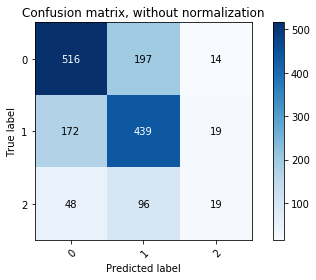

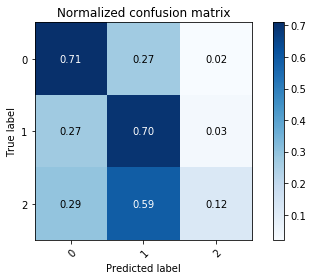

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

y_test = []
y_pred = []

for ind in range(len(true)):
  y_test.append(int(true[ind]))
  y_pred.append(int(pred[ind]))
# y_test = true
# y_pred = pred
class_names = np.array([0,1,2])
print(y_test[:5])

print(y_pred[:5])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
test_eval_examples = processor.get_test_examples(TASK_DATA_DIR)
model_eval(estimator_from_tfhub, test_eval_examples)

INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-0


INFO:tensorflow:guid: test-0


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ ' however she stated that the democratic ##ally elected government has every right to di ##cta ##te what constitutes an ugly front yard and gardens are apparently a contributing factor ' , ' there is no vegetable ban in miami shores village attorney richard sara ##fan told the judge ' , ' even though she ruled in favor of the ban judge monica go ##rdo acknowledged that she wasn ##t quite sure how a vegetable garden can ruin the aesthetics of ones property ' , ' there is no vegetable ban in miami shores sara ##fan [SEP]


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ ' however she stated that the democratic ##ally elected government has every right to di ##cta ##te what constitutes an ugly front yard and gardens are apparently a contributing factor ' , ' there is no vegetable ban in miami shores village attorney richard sara ##fan told the judge ' , ' even though she ruled in favor of the ban judge monica go ##rdo acknowledged that she wasn ##t quite sure how a vegetable garden can ruin the aesthetics of ones property ' , ' there is no vegetable ban in miami shores sara ##fan [SEP]


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 1005 2174 2016 3090 2008 1996 3537 3973 2700 2231 2038 2296 2157 2000 4487 25572 2618 2054 17367 2019 9200 2392 4220 1998 5822 2024 4593 1037 8020 5387 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 2352 4905 2957 7354 15143 2409 1996 3648 1005 1010 1005 2130 2295 2016 5451 1999 5684 1997 1996 7221 3648 9018 2175 20683 8969 2008 2016 2347 2102 3243 2469 2129 1037 15415 3871 2064 10083 1996 20749 1997 3924 3200 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 7354 15143 102


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 1005 2174 2016 3090 2008 1996 3537 3973 2700 2231 2038 2296 2157 2000 4487 25572 2618 2054 17367 2019 9200 2392 4220 1998 5822 2024 4593 1037 8020 5387 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 2352 4905 2957 7354 15143 2409 1996 3648 1005 1010 1005 2130 2295 2016 5451 1999 5684 1997 1996 7221 3648 9018 2175 20683 8969 2008 2016 2347 2102 3243 2469 2129 1037 15415 3871 2064 10083 1996 20749 1997 3924 3200 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 7354 15143 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-1


INFO:tensorflow:guid: test-1


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ ' the people we met had an almost religious affection for fide ##l castro ' , ' however the sanders family relationship sour ##ed after bernie was caught having sex with a niece of che gu ##eva ##ras ' , ' he recalled being very excited when fide ##l castro made a revolution in cuba in 1959 ' , ' from left daniel ortega bernie sanders nicolas mad ##uro and fide ##l castro ' , ' the sanders family lived in the cuban city of santa clara and the young sanders grew to admire che gu ##eva ##ra and fide [SEP]


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ ' the people we met had an almost religious affection for fide ##l castro ' , ' however the sanders family relationship sour ##ed after bernie was caught having sex with a niece of che gu ##eva ##ras ' , ' he recalled being very excited when fide ##l castro made a revolution in cuba in 1959 ' , ' from left daniel ortega bernie sanders nicolas mad ##uro and fide ##l castro ' , ' the sanders family lived in the cuban city of santa clara and the young sanders grew to admire che gu ##eva ##ra and fide [SEP]


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 1005 1996 2111 2057 2777 2018 2019 2471 3412 12242 2005 26000 2140 11794 1005 1010 1005 2174 1996 12055 2155 3276 14768 2098 2044 15941 2001 3236 2383 3348 2007 1037 12286 1997 18178 19739 13331 8180 1005 1010 1005 2002 7383 2108 2200 7568 2043 26000 2140 11794 2081 1037 4329 1999 7394 1999 3851 1005 1010 1005 2013 2187 3817 25859 15941 12055 9473 5506 10976 1998 26000 2140 11794 1005 1010 1005 1996 12055 2155 2973 1999 1996 9642 2103 1997 4203 10254 1998 1996 2402 12055 3473 2000 19837 18178 19739 13331 2527 1998 26000 102


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 1005 1996 2111 2057 2777 2018 2019 2471 3412 12242 2005 26000 2140 11794 1005 1010 1005 2174 1996 12055 2155 3276 14768 2098 2044 15941 2001 3236 2383 3348 2007 1037 12286 1997 18178 19739 13331 8180 1005 1010 1005 2002 7383 2108 2200 7568 2043 26000 2140 11794 2081 1037 4329 1999 7394 1999 3851 1005 1010 1005 2013 2187 3817 25859 15941 12055 9473 5506 10976 1998 26000 2140 11794 1005 1010 1005 1996 12055 2155 2973 1999 1996 9642 2103 1997 4203 10254 1998 1996 2402 12055 3473 2000 19837 18178 19739 13331 2527 1998 26000 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-2


INFO:tensorflow:guid: test-2


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ ' even if all retirement benefits were cut off today every man woman and child in chicago would owe more than 700 ##0 to cover obligations already incurred — an amount that doesn ##t include state pension debt of about 60 billion ' , ' the schools have capacity for about 1400 ##0 students ' , ' several schools would each house 1000 violent students ' , ' a job never done ##by the end of 2012 school [SEP]


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ ' even if all retirement benefits were cut off today every man woman and child in chicago would owe more than 700 ##0 to cover obligations already incurred — an amount that doesn ##t include state pension debt of about 60 billion ' , ' the schools have capacity for about 1400 ##0 students ' , ' several schools would each house 1000 violent students ' , ' a job never done ##by the end of 2012 school [SEP]


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 1005 2130 2065 2035 5075 6666 2020 3013 2125 2651 2296 2158 2450 1998 2775 1999 3190 2052 12533 2062 2084 6352 2692 2000 3104 14422 2525 22667 1517 2019 3815 2008 2987 2102 2421 2110 11550 7016 1997 2055 3438 4551 1005 1010 1005 1996 2816 2031 3977 2005 2055 20652 2692 2493 1005 1010 1005 2195 2816 2052 2169 2160 6694 6355 2493 1005 1010 1005 1037 3105 2196 2589 3762 1996 2203 1997 2262 2082 102


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 1005 2130 2065 2035 5075 6666 2020 3013 2125 2651 2296 2158 2450 1998 2775 1999 3190 2052 12533 2062 2084 6352 2692 2000 3104 14422 2525 22667 1517 2019 3815 2008 2987 2102 2421 2110 11550 7016 1997 2055 3438 4551 1005 1010 1005 1996 2816 2031 3977 2005 2055 20652 2692 2493 1005 1010 1005 2195 2816 2052 2169 2160 6694 6355 2493 1005 1010 1005 1037 3105 2196 2589 3762 1996 2203 1997 2262 2082 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-3


INFO:tensorflow:guid: test-3


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ ' fiscal cliff deal will raise taxes on 77 percent of americans tax policy center analysis ##wash ##ington while the tax package that congress passed new years day will protect 99 percent of americans from an income tax increase most of them will still end up paying more federal taxes in 2013 ' , ' investment taxes would increase for people who fall in the new top tax bracket ' , ' i voted to end tar ##p even though i voted for it initially because i think its been [SEP]


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ ' fiscal cliff deal will raise taxes on 77 percent of americans tax policy center analysis ##wash ##ington while the tax package that congress passed new years day will protect 99 percent of americans from an income tax increase most of them will still end up paying more federal taxes in 2013 ' , ' investment taxes would increase for people who fall in the new top tax bracket ' , ' i voted to end tar ##p even though i voted for it initially because i think its been [SEP]


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 1005 10807 7656 3066 2097 5333 7773 2006 6255 3867 1997 4841 4171 3343 2415 4106 28556 7853 2096 1996 4171 7427 2008 3519 2979 2047 2086 2154 2097 4047 5585 3867 1997 4841 2013 2019 3318 4171 3623 2087 1997 2068 2097 2145 2203 2039 7079 2062 2976 7773 1999 2286 1005 1010 1005 5211 7773 2052 3623 2005 2111 2040 2991 1999 1996 2047 2327 4171 21605 1005 1010 1005 1045 5444 2000 2203 16985 2361 2130 2295 1045 5444 2005 2009 3322 2138 1045 2228 2049 2042 102


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 1005 10807 7656 3066 2097 5333 7773 2006 6255 3867 1997 4841 4171 3343 2415 4106 28556 7853 2096 1996 4171 7427 2008 3519 2979 2047 2086 2154 2097 4047 5585 3867 1997 4841 2013 2019 3318 4171 3623 2087 1997 2068 2097 2145 2203 2039 7079 2062 2976 7773 1999 2286 1005 1010 1005 5211 7773 2052 3623 2005 2111 2040 2991 1999 1996 2047 2327 4171 21605 1005 1010 1005 1045 5444 2000 2203 16985 2361 2130 2295 1045 5444 2005 2009 3322 2138 1045 2228 2049 2042 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-4


INFO:tensorflow:guid: test-4


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ ' photo michelle pe ##mber ##ton ##ind ##yst ##ars ##oon sam is going to have less of a club ' , ' some demanded ref ##unds for their sam ##s club membership ##s which cost between 45 and 100 a year ' , ' here ##s the list ##cl ##ose wal ##mart has announced it is raising its starting hourly wage from 9 to 11 and sam ##s club is set to close a series of clubs across the united states ' , ' on thursday jan 11 2018 wal ##mart [SEP]


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ ' photo michelle pe ##mber ##ton ##ind ##yst ##ars ##oon sam is going to have less of a club ' , ' some demanded ref ##unds for their sam ##s club membership ##s which cost between 45 and 100 a year ' , ' here ##s the list ##cl ##ose wal ##mart has announced it is raising its starting hourly wage from 9 to 11 and sam ##s club is set to close a series of clubs across the united states ' , ' on thursday jan 11 2018 wal ##mart [SEP]


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 1005 6302 9393 21877 21784 2669 22254 27268 11650 7828 3520 2003 2183 2000 2031 2625 1997 1037 2252 1005 1010 1005 2070 6303 25416 26698 2005 2037 3520 2015 2252 5779 2015 2029 3465 2090 3429 1998 2531 1037 2095 1005 1010 1005 2182 2015 1996 2862 20464 9232 24547 22345 2038 2623 2009 2003 6274 2049 3225 21462 11897 2013 1023 2000 2340 1998 3520 2015 2252 2003 2275 2000 2485 1037 2186 1997 4184 2408 1996 2142 2163 1005 1010 1005 2006 9432 5553 2340 2760 24547 22345 102


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 1005 6302 9393 21877 21784 2669 22254 27268 11650 7828 3520 2003 2183 2000 2031 2625 1997 1037 2252 1005 1010 1005 2070 6303 25416 26698 2005 2037 3520 2015 2252 5779 2015 2029 3465 2090 3429 1998 2531 1037 2095 1005 1010 1005 2182 2015 1996 2862 20464 9232 24547 22345 2038 2623 2009 2003 6274 2049 3225 21462 11897 2013 1023 2000 2340 1998 3520 2015 2252 2003 2275 2000 2485 1037 2186 1997 4184 2408 1996 2142 2163 1005 1010 1005 2006 9432 5553 2340 2760 24547 22345 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


***** Started evaluation at 2019-12-12 16:21:35.211680 *****
  Num examples = 1520
  Batch size = 8
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-12T16:21:44Z


INFO:tensorflow:Starting evaluation at 2019-12-12T16:21:44Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Finished evaluation at 2019-12-12-16:22:01


INFO:tensorflow:Finished evaluation at 2019-12-12-16:22:01


INFO:tensorflow:Saving dict for global step 1140: eval_accuracy = 0.64736843, eval_loss = 0.97496957, global_step = 1140, loss = 0.8729264


INFO:tensorflow:Saving dict for global step 1140: eval_accuracy = 0.64736843, eval_loss = 0.97496957, global_step = 1140, loss = 0.8729264


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1140: gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1140: gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:evaluation_loop marked as finished


INFO:tensorflow:evaluation_loop marked as finished


***** Finished evaluation at 2019-12-12 16:22:02.480886 *****
***** Eval results *****
  eval_accuracy = 0.64736843
  eval_loss = 0.97496957
  global_step = 1140
  loss = 0.8729264


In [0]:
test_prediction_examples = processor.get_test_examples(TASK_DATA_DIR)
test_true, test_pred = model_predict(estimator_from_tfhub, test_prediction_examples)

INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:Writing example 0 of 1520


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-0


INFO:tensorflow:guid: test-0


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ ' however she stated that the democratic ##ally elected government has every right to di ##cta ##te what constitutes an ugly front yard and gardens are apparently a contributing factor ' , ' there is no vegetable ban in miami shores village attorney richard sara ##fan told the judge ' , ' even though she ruled in favor of the ban judge monica go ##rdo acknowledged that she wasn ##t quite sure how a vegetable garden can ruin the aesthetics of ones property ' , ' there is no vegetable ban in miami shores sara ##fan [SEP]


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ ' however she stated that the democratic ##ally elected government has every right to di ##cta ##te what constitutes an ugly front yard and gardens are apparently a contributing factor ' , ' there is no vegetable ban in miami shores village attorney richard sara ##fan told the judge ' , ' even though she ruled in favor of the ban judge monica go ##rdo acknowledged that she wasn ##t quite sure how a vegetable garden can ruin the aesthetics of ones property ' , ' there is no vegetable ban in miami shores sara ##fan [SEP]


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 1005 2174 2016 3090 2008 1996 3537 3973 2700 2231 2038 2296 2157 2000 4487 25572 2618 2054 17367 2019 9200 2392 4220 1998 5822 2024 4593 1037 8020 5387 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 2352 4905 2957 7354 15143 2409 1996 3648 1005 1010 1005 2130 2295 2016 5451 1999 5684 1997 1996 7221 3648 9018 2175 20683 8969 2008 2016 2347 2102 3243 2469 2129 1037 15415 3871 2064 10083 1996 20749 1997 3924 3200 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 7354 15143 102


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 1005 2174 2016 3090 2008 1996 3537 3973 2700 2231 2038 2296 2157 2000 4487 25572 2618 2054 17367 2019 9200 2392 4220 1998 5822 2024 4593 1037 8020 5387 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 2352 4905 2957 7354 15143 2409 1996 3648 1005 1010 1005 2130 2295 2016 5451 1999 5684 1997 1996 7221 3648 9018 2175 20683 8969 2008 2016 2347 2102 3243 2469 2129 1037 15415 3871 2064 10083 1996 20749 1997 3924 3200 1005 1010 1005 2045 2003 2053 15415 7221 1999 5631 13312 7354 15143 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-1


INFO:tensorflow:guid: test-1


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ ' the people we met had an almost religious affection for fide ##l castro ' , ' however the sanders family relationship sour ##ed after bernie was caught having sex with a niece of che gu ##eva ##ras ' , ' he recalled being very excited when fide ##l castro made a revolution in cuba in 1959 ' , ' from left daniel ortega bernie sanders nicolas mad ##uro and fide ##l castro ' , ' the sanders family lived in the cuban city of santa clara and the young sanders grew to admire che gu ##eva ##ra and fide [SEP]


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ ' the people we met had an almost religious affection for fide ##l castro ' , ' however the sanders family relationship sour ##ed after bernie was caught having sex with a niece of che gu ##eva ##ras ' , ' he recalled being very excited when fide ##l castro made a revolution in cuba in 1959 ' , ' from left daniel ortega bernie sanders nicolas mad ##uro and fide ##l castro ' , ' the sanders family lived in the cuban city of santa clara and the young sanders grew to admire che gu ##eva ##ra and fide [SEP]


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 1005 1996 2111 2057 2777 2018 2019 2471 3412 12242 2005 26000 2140 11794 1005 1010 1005 2174 1996 12055 2155 3276 14768 2098 2044 15941 2001 3236 2383 3348 2007 1037 12286 1997 18178 19739 13331 8180 1005 1010 1005 2002 7383 2108 2200 7568 2043 26000 2140 11794 2081 1037 4329 1999 7394 1999 3851 1005 1010 1005 2013 2187 3817 25859 15941 12055 9473 5506 10976 1998 26000 2140 11794 1005 1010 1005 1996 12055 2155 2973 1999 1996 9642 2103 1997 4203 10254 1998 1996 2402 12055 3473 2000 19837 18178 19739 13331 2527 1998 26000 102


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 1005 1996 2111 2057 2777 2018 2019 2471 3412 12242 2005 26000 2140 11794 1005 1010 1005 2174 1996 12055 2155 3276 14768 2098 2044 15941 2001 3236 2383 3348 2007 1037 12286 1997 18178 19739 13331 8180 1005 1010 1005 2002 7383 2108 2200 7568 2043 26000 2140 11794 2081 1037 4329 1999 7394 1999 3851 1005 1010 1005 2013 2187 3817 25859 15941 12055 9473 5506 10976 1998 26000 2140 11794 1005 1010 1005 1996 12055 2155 2973 1999 1996 9642 2103 1997 4203 10254 1998 1996 2402 12055 3473 2000 19837 18178 19739 13331 2527 1998 26000 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-2


INFO:tensorflow:guid: test-2


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ ' even if all retirement benefits were cut off today every man woman and child in chicago would owe more than 700 ##0 to cover obligations already incurred — an amount that doesn ##t include state pension debt of about 60 billion ' , ' the schools have capacity for about 1400 ##0 students ' , ' several schools would each house 1000 violent students ' , ' a job never done ##by the end of 2012 school [SEP]


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ ' even if all retirement benefits were cut off today every man woman and child in chicago would owe more than 700 ##0 to cover obligations already incurred — an amount that doesn ##t include state pension debt of about 60 billion ' , ' the schools have capacity for about 1400 ##0 students ' , ' several schools would each house 1000 violent students ' , ' a job never done ##by the end of 2012 school [SEP]


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 1005 2130 2065 2035 5075 6666 2020 3013 2125 2651 2296 2158 2450 1998 2775 1999 3190 2052 12533 2062 2084 6352 2692 2000 3104 14422 2525 22667 1517 2019 3815 2008 2987 2102 2421 2110 11550 7016 1997 2055 3438 4551 1005 1010 1005 1996 2816 2031 3977 2005 2055 20652 2692 2493 1005 1010 1005 2195 2816 2052 2169 2160 6694 6355 2493 1005 1010 1005 1037 3105 2196 2589 3762 1996 2203 1997 2262 2082 102


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 1005 2130 2065 2035 5075 6666 2020 3013 2125 2651 2296 2158 2450 1998 2775 1999 3190 2052 12533 2062 2084 6352 2692 2000 3104 14422 2525 22667 1517 2019 3815 2008 2987 2102 2421 2110 11550 7016 1997 2055 3438 4551 1005 1010 1005 1996 2816 2031 3977 2005 2055 20652 2692 2493 1005 1010 1005 2195 2816 2052 2169 2160 6694 6355 2493 1005 1010 1005 1037 3105 2196 2589 3762 1996 2203 1997 2262 2082 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-3


INFO:tensorflow:guid: test-3


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ ' fiscal cliff deal will raise taxes on 77 percent of americans tax policy center analysis ##wash ##ington while the tax package that congress passed new years day will protect 99 percent of americans from an income tax increase most of them will still end up paying more federal taxes in 2013 ' , ' investment taxes would increase for people who fall in the new top tax bracket ' , ' i voted to end tar ##p even though i voted for it initially because i think its been [SEP]


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ ' fiscal cliff deal will raise taxes on 77 percent of americans tax policy center analysis ##wash ##ington while the tax package that congress passed new years day will protect 99 percent of americans from an income tax increase most of them will still end up paying more federal taxes in 2013 ' , ' investment taxes would increase for people who fall in the new top tax bracket ' , ' i voted to end tar ##p even though i voted for it initially because i think its been [SEP]


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 1005 10807 7656 3066 2097 5333 7773 2006 6255 3867 1997 4841 4171 3343 2415 4106 28556 7853 2096 1996 4171 7427 2008 3519 2979 2047 2086 2154 2097 4047 5585 3867 1997 4841 2013 2019 3318 4171 3623 2087 1997 2068 2097 2145 2203 2039 7079 2062 2976 7773 1999 2286 1005 1010 1005 5211 7773 2052 3623 2005 2111 2040 2991 1999 1996 2047 2327 4171 21605 1005 1010 1005 1045 5444 2000 2203 16985 2361 2130 2295 1045 5444 2005 2009 3322 2138 1045 2228 2049 2042 102


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 1005 10807 7656 3066 2097 5333 7773 2006 6255 3867 1997 4841 4171 3343 2415 4106 28556 7853 2096 1996 4171 7427 2008 3519 2979 2047 2086 2154 2097 4047 5585 3867 1997 4841 2013 2019 3318 4171 3623 2087 1997 2068 2097 2145 2203 2039 7079 2062 2976 7773 1999 2286 1005 1010 1005 5211 7773 2052 3623 2005 2111 2040 2991 1999 1996 2047 2327 4171 21605 1005 1010 1005 1045 5444 2000 2203 16985 2361 2130 2295 1045 5444 2005 2009 3322 2138 1045 2228 2049 2042 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-4


INFO:tensorflow:guid: test-4


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ ' photo michelle pe ##mber ##ton ##ind ##yst ##ars ##oon sam is going to have less of a club ' , ' some demanded ref ##unds for their sam ##s club membership ##s which cost between 45 and 100 a year ' , ' here ##s the list ##cl ##ose wal ##mart has announced it is raising its starting hourly wage from 9 to 11 and sam ##s club is set to close a series of clubs across the united states ' , ' on thursday jan 11 2018 wal ##mart [SEP]


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ ' photo michelle pe ##mber ##ton ##ind ##yst ##ars ##oon sam is going to have less of a club ' , ' some demanded ref ##unds for their sam ##s club membership ##s which cost between 45 and 100 a year ' , ' here ##s the list ##cl ##ose wal ##mart has announced it is raising its starting hourly wage from 9 to 11 and sam ##s club is set to close a series of clubs across the united states ' , ' on thursday jan 11 2018 wal ##mart [SEP]


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 1005 6302 9393 21877 21784 2669 22254 27268 11650 7828 3520 2003 2183 2000 2031 2625 1997 1037 2252 1005 1010 1005 2070 6303 25416 26698 2005 2037 3520 2015 2252 5779 2015 2029 3465 2090 3429 1998 2531 1037 2095 1005 1010 1005 2182 2015 1996 2862 20464 9232 24547 22345 2038 2623 2009 2003 6274 2049 3225 21462 11897 2013 1023 2000 2340 1998 3520 2015 2252 2003 2275 2000 2485 1037 2186 1997 4184 2408 1996 2142 2163 1005 1010 1005 2006 9432 5553 2340 2760 24547 22345 102


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 1005 6302 9393 21877 21784 2669 22254 27268 11650 7828 3520 2003 2183 2000 2031 2625 1997 1037 2252 1005 1010 1005 2070 6303 25416 26698 2005 2037 3520 2015 2252 5779 2015 2029 3465 2090 3429 1998 2531 1037 2095 1005 1010 1005 2182 2015 1996 2862 20464 9232 24547 22345 2038 2623 2009 2003 6274 2049 3225 21462 11897 2013 1023 2000 2340 1998 3520 2015 2252 2003 2275 2000 2485 1037 2186 1997 4184 2408 1996 2142 2163 1005 1010 1005 2006 9432 5553 2340 2760 24547 22345 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_ids, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = input_mask, shape = (1, 128)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = label_ids, shape = (1,)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)


INFO:tensorflow:  name = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execut

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Restoring parameters from gs://550_finalproj/bert-tfhub/models/LP/repl/model.ckpt-1140


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 18 seconds


INFO:tensorflow:Initialized TPU in 18 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


[1, 0, 1, 1, 1]
[1, 0, 1, 1, 1]
classes first: [0 1 2]
Confusion matrix, without normalization
[[508 184  17]
 [166 461  10]
 [ 54 105  15]]
[0 1 2]
classes first: [0 1 2]
Normalized confusion matrix
[[0.72 0.26 0.02]
 [0.26 0.72 0.02]
 [0.31 0.6  0.09]]
[0 1 2]


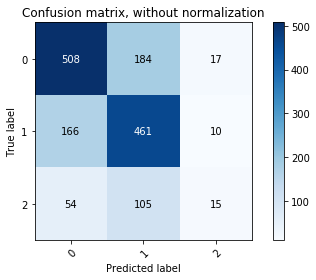

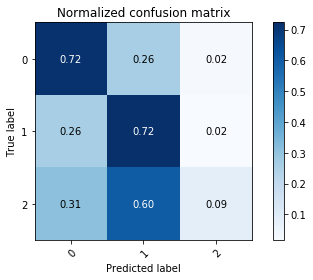

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print("classes first:", classes)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    print(classes)
    return ax


np.set_printoptions(precision=2)

y_test = []
y_pred = []

for ind in range(len(test_true)):
  y_test.append(int(test_true[ind]))
  y_pred.append(int(test_pred[ind]))
# y_test = true
# y_pred = pred
class_names = np.array([0,1,2])
print(y_test[:5])

print(y_pred[:5])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()